<span style="display:block;text-align:center;margin-right:105px"><img src="../media/logos/hacks-logo.png" width="200"/></span>

## Table of Contents

<ul>
    <li><a href='#Dependencies'>Dependencies</a></li>
    <li><a href='#Modelling'>Modelling</a>
        <ol style='margin-top: 0em;'>
            <li><a href='#1.-State-Variables'>State Variables</a></li>
            <li><a href='#2.-System-Parameters'>System Parameters</a></li>
            <li><a href='#3.-Policy-Functions'>Policy Functions</a></li>
            <li><a href='#4.-State-Update-Functions'>State Update Functions</a></li>
            <li><a href='#5.-Partial-State-Update-Blocks'>Partial State Update Blocks</a></li>
        </ol>
    </li>
    <li><a href='#Simulation'>Simulation</a>
        <ol style='margin-top: 0em;' start="6">
            <li><a href='#6.-Configuration'>Configuration</a></li>
            <li><a href='#7.-Execution'>Execution</a></li>
            <li><a href='#8.-Output-Preparation'>Output Preparation</a></li>
            <li><a href='#9.-Analysis'>Analysis</a></li>
        </ol>
    </li>
</ul>

---

# Dependencies

In [1]:
# cadCAD standard dependencies

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

# cadCAD global simulation configuration list
from cadCAD import configs

# Included with cadCAD
import pandas as pd

In [2]:
# Additional dependencies

# For analytics
import numpy as np
# For visualization
import plotly.express as px

# Modelling

## 1. State Variables

In [3]:
initial_state = {
    'predator_population': 15, # Initial number of predators
    'prey_population': 100, # Initial number of preys
}
initial_state

{'predator_population': 15, 'prey_population': 100}

## 2. System Parameters

In [4]:
system_params = {
    # Parameters describing the interaction between the two populations:
    
    # A parameter used to calculate the rate of predator birth
    "predator_birth_parameter": [0.01], 
    # A parameter used to calculate the rate of predator death
    "predator_death_parameter": [1.0],
    # A parameter used to calculate the rate of prey birth
    "prey_birth_parameter": [0.6, 1.0],
    # A parameter used to calculate the rate of prey death
    "prey_death_parameter": [0.03],

    # Parameters used for random Numpy variable tuning
    # These parameters scale the random variable used to create the random birth / death rate
    
    "random_predator_birth": [0.0002],
    "random_predator_death": [0.005],
    "random_prey_birth": [0.1],
    "random_prey_death": [0.1],

    # Parameter used as conversion factor between 1 unit of time and 1 timestep
    # 10 timesteps == 1 unit of time, i.e. every 10 cadCAD model timesteps, 1 unit of actual model time passes
    
    "dt": [0.1],
}

## 3. Policy Functions

In [5]:
def p_predator_births(params, substep, state_history, previous_state):
    '''Predator Births Policy Function
    The predator birth rate (rate of predators born per unit of time) is a product of
    the prey population and the predator birth parameter plus a random variable.
    
    i.e. the larger the prey population, the higher the predator birth rate
    '''
    # Parameters   
    dt = params['dt']
    predator_birth_parameter = params['predator_birth_parameter']
    random_predator_birth = params['random_predator_birth']

    # State Variables
    predator_population = previous_state['predator_population']
    prey_population = previous_state['prey_population']

    # Calculate the predator birth rate
    birth_rate = prey_population * (predator_birth_parameter + np.random.random() * random_predator_birth)
    # Calculate change in predator population
    births = birth_rate * predator_population * dt

    return {'add_to_predator_population': births}


def p_predator_deaths(params, substep, state_history, previous_state):
    '''Predator Deaths Policy Function
    The predator death rate (rate of predators that die per unit of time) is a function of
    the predator death parameter plus a random variable.
    
    i.e. the larger the predator death parameter, the higher the predator death rate
    '''
    # Parameters
    dt = params['dt']
    predator_death_parameter = params['predator_death_parameter']
    random_predator_death = params['random_predator_death']

    # State Variables
    predator_population = previous_state['predator_population']

    # Calculate the predator death rate
    death_rate = predator_death_parameter + np.random.random() * random_predator_death
    # Calculate change in predator population
    deaths = death_rate * predator_population * dt

    return {'add_to_predator_population': -1.0 * deaths}


def p_prey_births(params, substep, state_history, previous_state):
    '''Prey Births Policy Function
    The prey birth rate (rate of preys born per unit of time) is a function of
    the prey birth parameter plus a random variable.
    
    i.e. the larger the prey birth parameter, the higher the prey birth rate
    '''
    # Parameters
    dt = params['dt']
    prey_birth_parameter = params['prey_birth_parameter']
    random_prey_birth = params['random_prey_birth']

    # State Variables
    prey_population = previous_state['prey_population']

    # Calculate the prey birth rate
    birth_rate = prey_birth_parameter + np.random.random() * random_prey_birth
    # Calculate change in prey population
    births = birth_rate * prey_population * dt

    return {'add_to_prey_population': births}


def p_prey_deaths(params, substep, state_history, previous_state):
    '''Prey Deaths Policy Function
    The prey death rate (rate of preys that die per unit of time) is a product of
    the predator population and the prey death parameter plus a random variable.
    
    i.e. the larger the predator population, the higher the prey death rate
    '''
    # Parameters
    dt = params['dt']
    prey_death_parameter = params['prey_death_parameter']
    random_prey_death = params['random_prey_death']

    # State Variables
    prey_population = previous_state['prey_population']
    predator_population = previous_state['predator_population']

    # Calculate the prey death rate
    death_rate = predator_population * (prey_death_parameter + np.random.random() * random_prey_death)
    # Calculate change in prey population
    deaths = death_rate * prey_population * dt

    return {'add_to_prey_population': -1.0 * deaths}

## 4. State Update Functions

In [6]:
def s_predator_population(params, substep, state_history, previous_state, policy_input):
    '''Predator Population State Update Function
    Take the Policy Input `add_to_predator_population`
    (the net predator births and deaths)
    and add to the `predator_population` State Variable.
    '''
    # Policy Inputs
    add_to_predator_population = policy_input['add_to_predator_population']

    # State Variables
    predator_population = previous_state['predator_population']

    # Calculate updated predator population
    updated_predator_population = predator_population + add_to_predator_population

    return 'predator_population', updated_predator_population


def s_prey_population(params, substep, state_history, previous_state, policy_input):
    '''Prey Population State Update Function
    Take the Policy Input `add_to_prey_population`
    (the net prey births and deaths)
    and add to the `prey_population` State Variable.
    '''
    # Policy Inputs
    add_to_prey_population = policy_input['add_to_prey_population']

    # State Variables
    prey_population = previous_state['prey_population']

    # Calculate updated prey population
    updated_prey_population = prey_population + add_to_prey_population

    return 'prey_population', updated_prey_population

## 5. Partial State Update Blocks

In [7]:
partial_state_update_blocks = [
    { 
        'label': 'Lotka Volterra Equations #1',
        'comments': 'The usual Prey & Predator model',
        # Configure the model Policy Functions
        'policies': {
            # Calculate the predator birth rate and number of births
            'predator_births': p_predator_births,
            # Calculate the predator death rate and number of deaths
            'predator_deaths': p_predator_deaths,
            # Calculate the prey birth rate and number of births
            'prey_births': p_prey_births,
            # Calculate the prey death rate and number of deaths
            'prey_deaths': p_prey_deaths,
        },
        # Configure the model State Update Functions
        'variables': {
            # Update the predator population
            'predator_population': s_prey_population,
            # Update the prey population
            'prey_population': s_predator_population
        }
    },
    {
        'label': 'Do Nothing',
        'comments': 'PSUB that does nothing',
        'ignore': False,
        'policies': {},
        'variables': {}
    },
    { 
        'label': 'Lotka Volterra Equations #2',
        'comments': 'This will be filtered',
        'ignore': True,
        # Configure the model Policy Functions
        'policies': {
            # Calculate the predator birth rate and number of births
            'predator_births': p_predator_births,
            # Calculate the predator death rate and number of deaths
            'predator_deaths': p_predator_deaths,
            # Calculate the prey birth rate and number of births
            'prey_births': p_prey_births,
            # Calculate the prey death rate and number of deaths
            'prey_deaths': p_prey_deaths,
        },
        # Configure the model State Update Functions
        'variables': {
            # Update the predator population
            'predator_population': s_prey_population,
            # Update the prey population
            'prey_population': s_predator_population
        }
    },
]

# Filter the PSUBs with ignore=True
partial_state_update_blocks = [psub
                               for psub in partial_state_update_blocks
                               if psub.get('ignore', False) is False]

partial_state_update_blocks

[{'label': 'Lotka Volterra Equations #1',
  'comments': 'The usual Prey & Predator model',
  'policies': {'predator_births': <function __main__.p_predator_births(params, substep, state_history, previous_state)>,
   'predator_deaths': <function __main__.p_predator_deaths(params, substep, state_history, previous_state)>,
   'prey_births': <function __main__.p_prey_births(params, substep, state_history, previous_state)>,
   'prey_deaths': <function __main__.p_prey_deaths(params, substep, state_history, previous_state)>},
  'variables': {'predator_population': <function __main__.s_prey_population(params, substep, state_history, previous_state, policy_input)>,
   'prey_population': <function __main__.s_predator_population(params, substep, state_history, previous_state, policy_input)>}},
 {'label': 'Do Nothing',
  'comments': 'PSUB that does nothing',
  'ignore': False,
  'policies': {},
  'variables': {}}]

# Simulation

## 6. Configuration

In [8]:
sim_config = config_sim({
    "N": 20, # the number of times we'll run the simulation ("Monte Carlo runs")
    "T": range(400), # the number of timesteps the simulation will run for
    "M": system_params # the parameters of the system
})

In [9]:
del configs[:] # Clear any prior configs

In [10]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

## 7. Execution

In [11]:
exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 2
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (400, 9, 20, 2)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Ns       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 1.51s


## 8. Output Preparation

In [12]:
# Convert raw results to a Pandas DataFrame
df = pd.DataFrame(raw_result)

# Insert cadCAD parameters for each configuration into DataFrame
for config in configs:
    # Get parameters from configuration
    parameters = config.sim_config['M']
    # Get subset index from configuration
    subset_index = config.subset_id
    
    # For each parameter key value pair
    for (key, value) in parameters.items():
        # Select all DataFrame indices where subset == subset_index
        dataframe_indices = df.eval(f'subset == {subset_index}')
        # Assign each parameter key value pair to the DataFrame for the corresponding subset
        df.loc[dataframe_indices, key] = value

df.head(10)

predator_population  prey_population  simulation  subset  run  substep  \
0            15.000000       100.000000           0       0    1        0   
1            15.024400        95.478003           0       0    1        1   
2            15.024400        95.478003           0       0    1        2   
3            14.958161        83.405073           0       0    1        1   
4            14.958161        83.405073           0       0    1        2   
5            14.732124        80.473148           0       0    1        1   
6            14.732124        80.473148           0       0    1        2   
7            14.455254        77.890540           0       0    1        1   
8            14.455254        77.890540           0       0    1        2   
9            14.140892        73.242414           0       0    1        1   

   timestep  predator_birth_parameter  predator_death_parameter  \
0         0                      0.01                       1.0   
1         1                      0.01                       1.0   
2         1                      0.01                       1.0   
3         2                      0.01                       1.0   
4         2                      0.01                       1.0   
5         3                      0.01                       1.0   
6         3                      0.01                       1.0   
7         4                      0.01                       1.0   
8         4                      0.01                       1.0   
9         5                      0.01                       1.0   

   prey_birth_parameter  prey_death_parameter  random_predator_birth  \
0                   0.6                  0.03                 0.0002   
1                   0.6                  0.03                 0.0002   
2                   0.6                  0.03                 0.0002   
3                   0.6                  0.03                 0.0002   
4                   0.6                  0.03                 0.0002   
5                   0.6                  0.03                 0.0002   
6                   0.6                  0.03                 0.0002   
7                   0.6                  0.03                 0.0002   
8                   0.6                  0.03                 0.0002   
9                   0.6                  0.03                 0.0002   

   random_predator_death  random_prey_birth  random_prey_death   dt  
0                  0.005                0.1                0.1  0.1  
1                  0.005                0.1                0.1  0.1  
2                  0.005                0.1                0.1  0.1  
3                  0.005                0.1                0.1  0.1  
4                  0.005                0.1                0.1  0.1  
5                  0.005                0.1                0.1  0.1  
6                  0.005                0.1                0.1  0.1  
7                  0.005                0.1                0.1  0.1  
8                  0.005                0.1                0.1  0.1  
9                  0.005                0.1                0.1  0.1

In [13]:
# Create a substep -> label mapping
# For each PSUB on the partial_state_update_blocks,
# we'll retrieve the 'label' key
# and associate it with the order on the PSUB.
psub_map = {order + 1: psub.get('label', '')
            for (order, psub) 
            in enumerate(partial_state_update_blocks)}

# Set substep=0 as being the inital state
psub_map[0] = 'Initial State'

# Create a new column called "substep" label
df['substep_label'] = df.substep.map(psub_map)

# Show the first 10 rows, last 8 columns.
df.iloc[0:10, -8:]

prey_birth_parameter  prey_death_parameter  random_predator_birth  \
0                   0.6                  0.03                 0.0002   
1                   0.6                  0.03                 0.0002   
2                   0.6                  0.03                 0.0002   
3                   0.6                  0.03                 0.0002   
4                   0.6                  0.03                 0.0002   
5                   0.6                  0.03                 0.0002   
6                   0.6                  0.03                 0.0002   
7                   0.6                  0.03                 0.0002   
8                   0.6                  0.03                 0.0002   
9                   0.6                  0.03                 0.0002   

   random_predator_death  random_prey_birth  random_prey_death   dt  \
0                  0.005                0.1                0.1  0.1   
1                  0.005                0.1                0.1  0.1   
2                  0.005                0.1                0.1  0.1   
3                  0.005                0.1                0.1  0.1   
4                  0.005                0.1                0.1  0.1   
5                  0.005                0.1                0.1  0.1   
6                  0.005                0.1                0.1  0.1   
7                  0.005                0.1                0.1  0.1   
8                  0.005                0.1                0.1  0.1   
9                  0.005                0.1                0.1  0.1   

                 substep_label  
0                Initial State  
1  Lotka Volterra Equations #1  
2                   Do Nothing  
3  Lotka Volterra Equations #1  
4                   Do Nothing  
5  Lotka Volterra Equations #1  
6                   Do Nothing  
7  Lotka Volterra Equations #1  
8                   Do Nothing  
9  Lotka Volterra Equations #1

## 9. Analysis

In [14]:
pd.options.plotting.backend = "plotly"

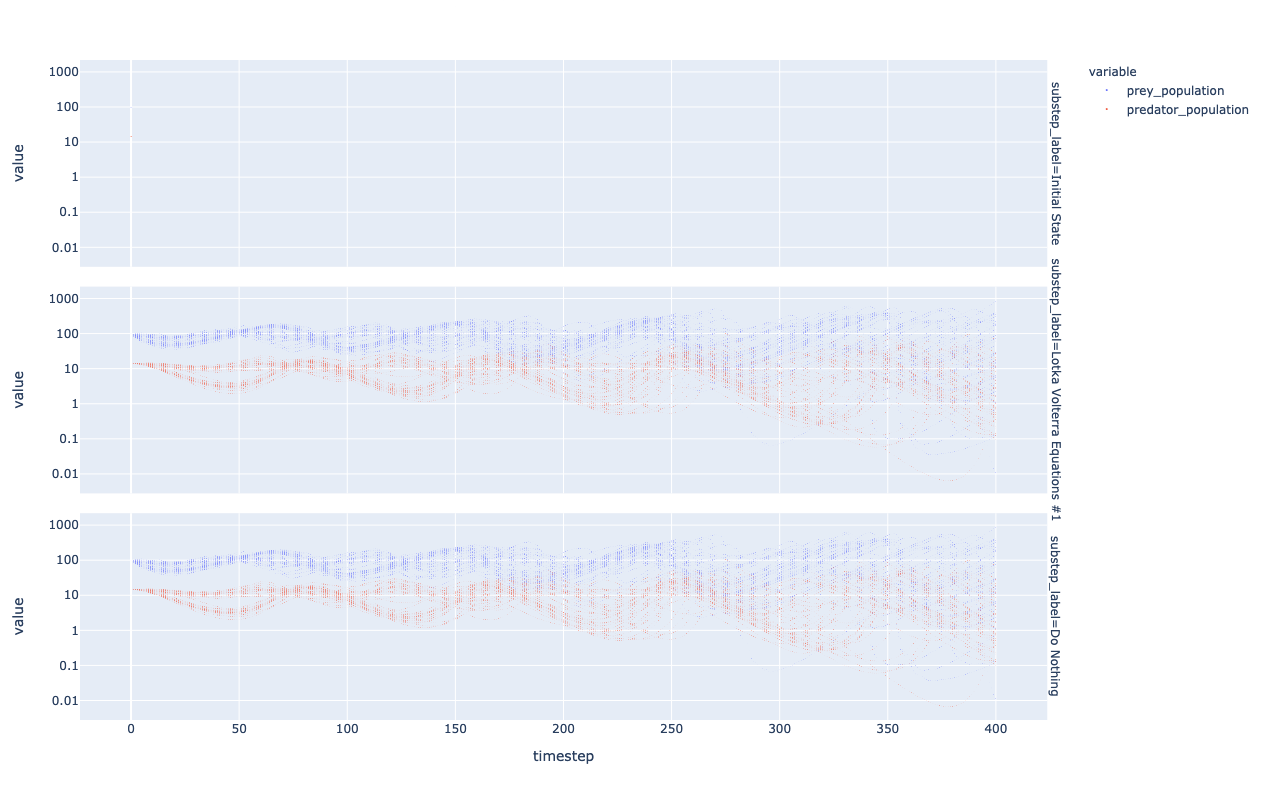

In [15]:
# Visualize how the predator and prey populations change over time

# Notice that the populations are more chaotic when the prey birth rate is higher,
# and the system is more stable when it is lower.

fig = px.scatter(
    df,
    x='timestep', # Variable on the horizontal axis
    y=['prey_population', 'predator_population'], # Variables on the vertical axis
    facet_row='substep_label', # Have a figure for different PSUB label
    log_y=True, # Use log scale on the vertical axis
    width=800,
    height=800
)

# Make the markers smaller
fig.update_traces(marker={'size': 1})
fig.show()